In [2]:
import numpy as np
import pandas as pd
import random

from pprint import pprint

from scipy import linalg as LA
from scipy.optimize import minimize
from scipy.optimize import BFGS

import matplotlib.pyplot as plt
from matplotlib.lines import Line2D


In [125]:

ENTANGLER_MAP = [[0,1],[1,2],[2,3],[3,4],[4,5],[5,6],[6,7],[7,8]]
#ENTANGLER_MAP_QIDA= [[0,1],[1,2],[2,5],[5,8],[8,7],[7,6],[6,3]]
ENTANGLER_MAP_QIDA= [[0,1],[1,2],[2,5],[5,8],[7,8],[6,7],[3,6]]
ENTANGLER_MAP_3x4_A = [[0,1],[1,2],[8,9],[10,11]]

In [126]:
#EXTRACT RANDOM COLOR
def randomColor():
    color = random.randrange(0, 2**24)
    hex_color = hex(color)
    std_color = "#" + hex_color[2:]
    return std_color

In [187]:
#EXTRACT ONLY PARAMS t1 AND t2 OF THE N_BLOCK
def extract_N_block(paramslist,ent,depth,offset):
    ct = len(ent)
    n = len(set(np.array(ent).flatten()))
    paramslist = paramslist[n::]
    sliced = []
    for i in range(depth):
        for _ in range(ct):
            if i > (offset-1):
                sliced.append(paramslist[:6:])
            paramslist = paramslist[6::]
        paramslist = paramslist[n::]
    
    relevant = []
    for s in sliced:
        relevant.append(s[:2:]) #[:2:] for firs couple (Ry,Ry on 1/2 quit) [2:4:] for second couple (entangling one 2 qubit) [4:6:] last couple
    if relevant == []:
        return [],  []
    else:
        relevant = list(np.concatenate(relevant).flat)
        x_ = relevant[::2]
        y_ = relevant[1::2]
        return x_,y_

In [128]:
#EXTRACT INDEX, ENERGIES and COLORS FOR EACH
def plt_energies(data:dict):
    i = []
    en = []
    for item in data:
        i.append(item['Index'])
        en.append(item['Energy'])
    return i,en

In [129]:
#SIMPLY COMPUTE STATS mean, min(best vqe), std and index of best vqe
def stats(e,i):
    return np.mean(e), np.min(e), np.std(e), np.where(e == np.min(e))[0][0]

In [130]:
#CLUSTER THE VQE BASED ON THE DIFFERENCE FROM THE BEST ONE
def threshold_cluster(en, cluster):
    m = np.min(en)
    M = np.max(en)
    n_th = cluster
    delta = np.abs(M - m)/n_th
    th = [m for _ in range(n_th)]
    th_colors = ['black', '#79002d', '#dc1e72', '#db6fb5', '#dbc8e2']
    l = []
    for j in range(n_th):
        th[j] = m+(delta*j)
    associations = []
    
    for e in en:
        for t in range(len(th)):
            if e<=th[t]:
                l.append(t)
                associations.append(th_colors[t])
                break
        else:

            l.append(len(th))
            associations.append(th_colors[-1])
    return associations, th_colors, delta,l


In [131]:
#CREATE LEGEND OF THE PLOT
def createLegend(cl,string):
    legend = []

    for item,i in enumerate(cl):
        legend.append(Line2D([0], [0], marker='o', color=cl[item], label=string.format(item), markersize=15))
    return legend



FIND THE OPTIMAL VQE FOR QIDA 
1 Layer, 7 entangling gates, 9 qubits


In [132]:

def extract_df(ent, r_col,f,size,depth):
    df = []
    for i in range(1,size+1):
        p = pd.read_pickle(f.format(i,depth))[0]
        x_,y_ = extract_N_block(p["Optimal_params"],ent, depth,0)
        data = dict()
        if r_col:
            c = randomColor()
            while len(c)!=7:
                c = randomColor()
        if r_col:
            data.update({"x_params":x_, "y_params":y_, "color": c,"Energy":p['Energy'],"Index": i })
        else:
            data.update({"x_params":x_, "y_params":y_, "Energy":p['Energy'], "Index": i })

        df.append(data)
    return df


In [133]:
#CHECK DI QUESTA FUNZIONE
#RIMOSSO INDICE
def clean_df(en,i):
    new_en = []
    new_i = []
    mean_e = np.mean(en)
    for e in range(len(en)):
        if mean_e>=en[e]:
            new_en.append(en[e])
            new_i.append(i[e])
        else:
            pass
    return new_i, new_en

In [134]:
#CREATE PARAMETERS PAIRS
def parameter_pair(df, i,ass):
    x_ = []
    y_ = []
    rep = len(df[0]['x_params'])
    for item in df:
        if item['Index'] in i:
            x_.append(item["x_params"])
            y_.append(item["y_params"])
    cmap = list()
    for item in ass:
        for _ in range(rep):
            cmap.append(item)

    return x_,y_,cmap

In [135]:
def parameter_pair_multilayer(color_list, reps):
    parameters_color = []
    for i in range(len(color_list)):
        for _ in range(reps[i]):
            parameters_color.append(color_list[i])
    return parameters_color

In [136]:
def size_plot (idx, s_min, s_all, l, rep):
    temp = []
    temp_a = []
    for i in range(l):
        if i == idx:
            temp.append(s_min)
            temp_a.append(1)
        else:
            
            temp.append(s_all)
            temp_a.append(0.4)
    s = []
    a = []
    for item in range(len(temp)):
        for _ in range(rep):
            s.append(temp[item])
            a.append(temp_a[item])
    return s, a

In [137]:
#SELECT ONLY SOME THRESHOLDS
def cut_th(en,i,col,l,th):
    new_en = []
    new_col = []
    new_i = [] 
    for j in range(len(l)):
        if l[j] < th:
            new_en.append(en[j])
            new_col.append(col[j])
            new_i.append(i[j])
    return new_en, new_i, new_col

CREAZIONE PLOT CON COLOMAp DIVISA PER SOGLIE

-3.9704454154823106
-3.9704454154823106 398
-3.9704454154823106 398


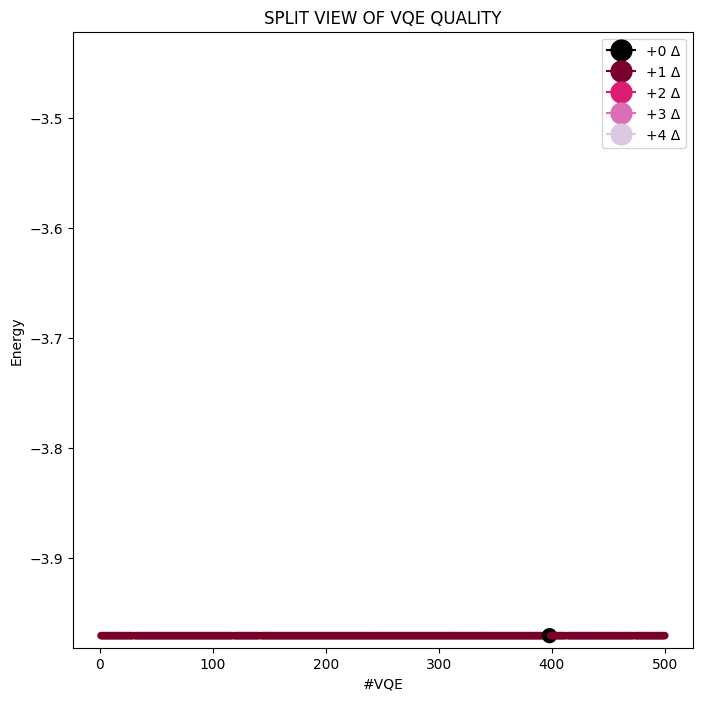

In [188]:

file_qida = "./pickle/vqe{}_3x3_{}A+_SU4.pkl"

#file_qida = "./pickle/{}_3x4_{}ASU4.pkl"
file_ladder = "./pickle/vqe{}_3x3_ladder_{}SU4.pkl"
system = '3x4'

df = extract_df(ent=ENTANGLER_MAP_QIDA, r_col=False, f=file_qida, size = 500, depth=1)
i,en= plt_energies(data = df)
print(np.min(en))
_, best_vqe, vqe_std, best_vqe_ind = stats(en, i)
print(best_vqe, i[best_vqe_ind])
#i,en = clean_df(en,i)
col,legend_color,delta,l = threshold_cluster(en=en, cluster = 5)

stop_th = 5


en, i, col= cut_th(en=en,i=i, l=l, th=stop_th, col = col)
_,best_vqe,_, best_vqe_ind = stats(en, i)
print(best_vqe,i[best_vqe_ind])


plt.figure(figsize=(8, 8))
s = [20]*len(i)
s[best_vqe_ind] = 100


plt.scatter(i, en, s=s,c = col)

string = "+{} Δ"
plt.legend(handles=createLegend(legend_color[:stop_th],string))

#plt.xlim(0,len(en)+1)
if system == '3x3':
    plt.axhline(-4.7493272585529, c='b')
    plt.axhline(-3, c='r')
elif system =='3x4':
    plt.axhline(-6,69168019351493, c='b')
    plt.axhline(-0,25, c='r')
plt.ylim(np.min(en)-(delta/10), np.max(en)+(5*delta))

plt.xlabel('#VQE')
plt.ylabel('Energy')

plt.title('SPLIT VIEW OF VQE QUALITY')
plt.show()


[[-1.7774709600514735, -2.587038664456995, -2.019721353081906, -3.280460195314975, -0.1447428482893078, 2.903092810226145, 0.6719652795631151], [-2.575647611227066, 0.029906280690932714, 2.36827055096456, 2.306410451262938, 2.0336630099634, -1.9773615271511855, -1.2021149849447001], [3.2885092556403928, 2.3154100229643912, -3.017270557687712, -3.1316027942829354, -1.8211269947333977, -0.6266818628679643, 0.06431047420801161], [-0.3556074633497936, -0.5315046483914044, 2.0269763694395473, -0.5251050599491182, 1.081646353820477, 1.8439820713186814, -0.849208342071208], [2.118877792959065, -1.2528239783788058, 1.8150772278993104, 3.6094516656383084, -0.14398378326778072, -3.3355758612953634, -0.295473965695431], [-1.7399907980342173, 2.181726259500503, -0.4583850284000892, -1.203581744891805, -0.776868082818497, 2.1707641974809033, -2.176610728859785], [2.4237354975489684, -2.1660934537728322, -2.06251934706894, -0.9521752339598111, 0.6097565027815294, -1.0980075863586978, -2.888874422452

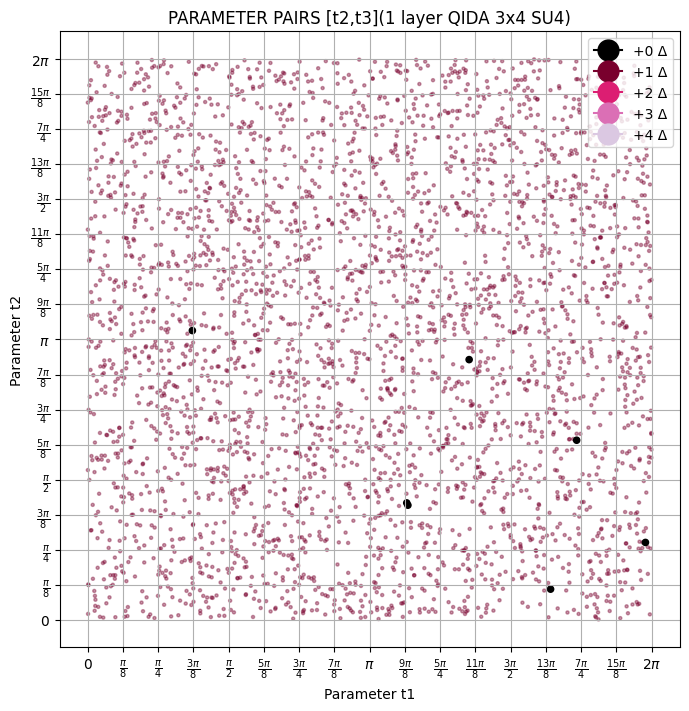

In [190]:
x_param, y_param, cmap = parameter_pair(df=df,i=i,ass = col)
print(x_param, len(y_param), len(cmap))
s, a = size_plot(idx=best_vqe_ind, s_min=20, s_all=5, l=len(en), rep = int(len(cmap)/len(en)))


plt.figure(figsize = (8,8))
plt.title("PARAMETER PAIRS [t2,t3](1 layer QIDA 3x4 SU4)")
string = "+{} Δ"
plt.legend(handles=createLegend(legend_color[:stop_th],string))

plt.scatter(np.mod(x_param,2*np.pi), np.mod(y_param, 2*np.pi), c=cmap, alpha=a, s=s)

plt.xticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.yticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.grid(True)
plt.xlabel('Parameter t1')
plt.ylabel('Parameter t2')
plt.show()

LADDER RESULTS


In [54]:

def extract_df_multidepth(depth,offset, ent,f,size):
    vqe_colors = []
    param_colors = []
    rep = []
    color_label  = ['black', '#79002d', '#dc1e72', '#db6fb5', '#fc9dbc','#dbc8e2','grey']
    total_x = []
    total_y = []
    en = []
    index = []
    
    for j in range(offset,depth+1):
        for i in range(1,size+1):
            p = pd.read_pickle(f.format(i,j))[0]
            x_,y_ = extract_N_block(p["Optimal_params"],ent, j,0)
            en.append(p["Energy"])
            total_x.append(x_)
            total_y.append(y_)
            for _ in range(len(x_)):
                param_colors.append(color_label[j-1])

            rep.append(len(x_))
            vqe_colors.append(color_label[j-1])
            index.append(i+(j-1)*size)
    return total_x, total_y, color_label, param_colors,vqe_colors,rep, index, en

In [55]:
file_ladder = "./pickle/vqe{}_3x3_ladder_{}SU4.pkl"

offset = 1
depth = 7
total_x,total_y,color_label,colors,vqe_colors,reps,index,en = extract_df_multidepth(depth=depth,offset=offset,ent=ENTANGLER_MAP, f=file_ladder, size = 50)
print(len(index), len(en))
total_x = list(np.concatenate(total_x).flat)
total_y = list(np.concatenate(total_y).flat)
print(reps)

350 350
[8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 8, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 16, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 24, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 32, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 40, 48, 48, 48, 48, 48, 48, 48, 48, 48, 48, 4

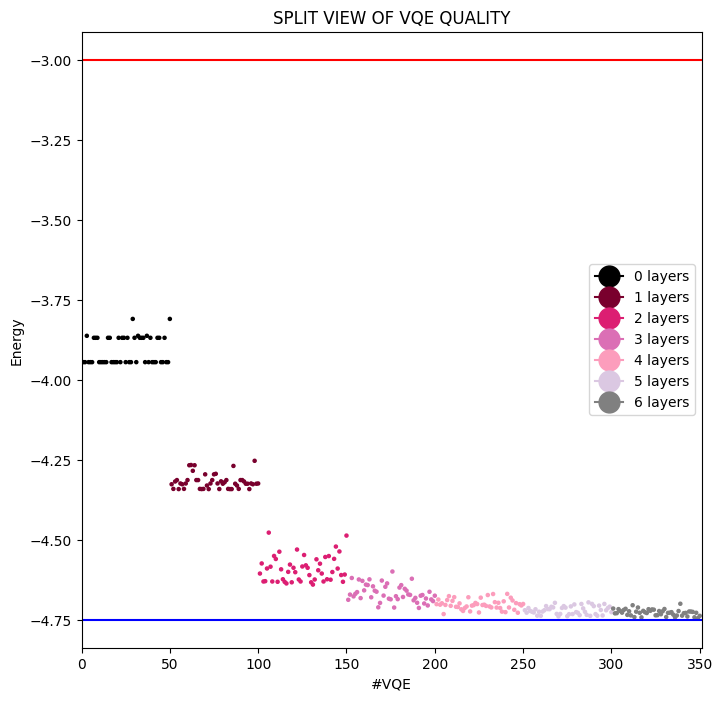

In [56]:
plt.figure(figsize=(8, 8))
s = 5
string = "{} layers"
if offset==depth:
    col,legend_color,delta,l = threshold_cluster(en=en, cluster = 5) 
    vqe_colors = col
    color_label = legend_color
    _,best_vqe,_, best_vqe_ind = stats(en, index)
    s = [20]*len(index)
    s[best_vqe_ind] = 100
    string = "+{} Δ"
    
plt.scatter(index, en, s=s,c=vqe_colors)

plt.axhline(-4.7493272585529, c='b')
plt.axhline(-3, c='r')
plt.legend(handles=createLegend(color_label, string))

plt.xlim(50*(offset-1),len(en)*(offset)+1)
#plt.ylim(np.min(en)-(delta/10), np.max(en)+(delta))

plt.xlabel('#VQE')
plt.ylabel('Energy')

plt.title('SPLIT VIEW OF VQE QUALITY')
plt.show()

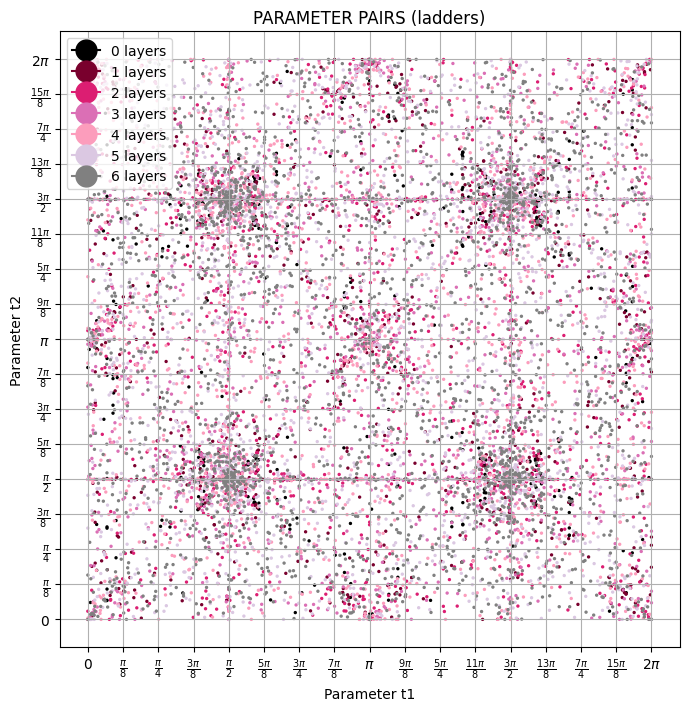

In [57]:
a = 1
s = 2
if depth == offset:
    colors = parameter_pair_multilayer(vqe_colors, reps)
    s, a = size_plot(idx=best_vqe_ind, s_min=20, s_all=5, l=len(en), rep = reps[0])  
plt.figure(figsize = (8,8))
plt.title("PARAMETER PAIRS (ladders)")
plt.legend(handles=createLegend(color_label, string))

plt.scatter(np.mod(total_x,2*np.pi), np.mod(total_y, 2*np.pi), c=colors, alpha=a, s=s)

plt.xticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.yticks(np.linspace(0, 2*np.pi, 17), [r'$0$',  r'$\frac{\pi}{8}$', r'$\frac{\pi}{4}$', r'$\frac{3\pi}{8}$', r'$\frac{\pi}{2}$', r'$\frac{5\pi}{8}$',
                                        r'$\frac{3\pi}{4}$', r'$\frac{7\pi}{8}$', r'$\pi}$', r'$\frac{9\pi}{8}$', r'$\frac{5\pi}{4}$', r'$\frac{11\pi}{8}$',
                                        r'$\frac{3\pi}{2}$', r'$\frac{13\pi}{8}$', r'$\frac{7\pi}{4}$', r'$\frac{15\pi}{8}$', r'$2\pi$'])
plt.grid(True)
plt.xlabel('Parameter t1')
plt.ylabel('Parameter t2')
plt.show()

CLUSTER ROTATION MATRICES

In [1]:
import numpy as np
# 1-QUBIT GATES
I = np.eye(2)
Z = np.array([[1., 0.],[0. ,-1.]])
X = np.array([[0., 1.],[1. ,0.]])
Y = np.array([[0., -1.j],[1.j ,0.]])

# 2-QUBITs GATES
I4 = np.eye(4)
CNOT1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
CNOT2 = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])

CZ = np.array([[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]])

CY1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,-1j],[0,0,1j,0]])
CY2 = np.array([[1,0,0,0],[0,0,0,-1j],[0,0,1,0],[0,1j,0,0]])

CH1 = np.array([[1,0,0,0],[0,1,0,0],[0,0,1/np.sqrt(2),1/np.sqrt(2)],[0,0,1/np.sqrt(2),-1/np.sqrt(2)]])
CH2 = np.array([[1,0,0,0],[0,1/np.sqrt(2),0,1/np.sqrt(2)],[0,0,1,0],[0,1/np.sqrt(2),0,-1/np.sqrt(2)]])

SWAP = np.array([[1,0,0,0],[0,0,1,0],[0,1,0,0],[0,0,0,1]])
iSWAP = np.array([[1,0,0,0],[0,0,1j,0],[0,1j,0,0],[0,0,0,1]])

M_LIST = [I4, 
          CNOT1, CNOT2,
          CZ,
          CY1,
          CY2,
          CH1,
          CH2,
          SWAP, iSWAP]


In [258]:

def compose_real_su4(params):

        CNOT2 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
        CNOT1 = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])

        I = np.eye(2)
        def Ry(theta):
            a = np.cos(theta/2)
            b = np.sin(theta/2)
            return np.array([[a,-b],[b,a]])
        
        def su_2(x):
            return np.kron(Ry(x[1]),I) @ np.kron(I, Ry(x[0]))
        
        def swap_block(x):
            return CNOT2 @ np.kron(Ry(x[1]),I) @ CNOT1 @ np.kron(Ry(x[0]), I) @ CNOT2
        
        return [[1,0,0,0],[0,1,0,0],[0,0,1,0],[0,0,0,-1]]@su_2([params[4],params[5]]) @ swap_block([params[2], params[3]]) @ su_2([params[0], params[1]])

def compose_su4(params):

    CNOT2 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
    CNOT1 = np.array([[1,0,0,0],[0,0,0,1],[0,0,1,0],[0,1,0,0]])

    I = np.eye(2)
    def ry(theta):
        a = np.cos(theta/2)
        b = np.sin(theta/2)
        return np.array([[a,-b],[b,a]])

    def rz(theta):
        a = np.exp(-1j*theta/2)
        b = np.exp(1J*theta/2)
        return np.array([[a,0],[0,b]])

    def swap_block(x):
        return CNOT2 @ np.kron(ry(x[2]),I) @ CNOT1 @ np.kron(ry(x[1]), I) @ np.kron(I, rz(x[0])) @ CNOT2

    #COMPOSE GENERAL SU(2) FROM PARAMETERS t1, t2 AND t3
    def general_su2(x):
        return np.kron(ry(x[5])@rz(x[4])@ry(x[3]),I) @ np.kron(I, ry(x[2])@rz(x[1])@ry(x[0]))
    
    return np.array(np.eye(4)*np.exp(-1j*np.pi)) @ general_su2(params[9:15:]) @ swap_block(params[6:9:]) @ general_su2(params[:6:])

def compose_orth4(params):

        CNOT2 = np.array([[1,0,0,0],[0,1,0,0],[0,0,0,1],[0,0,1,0]])
        S = np.array([[1,0],[0,1.j]])
        Sdag = np.array([[1,0],[0,-1j]])
        
        I = np.eye(2)

        def ry(theta):
            a = np.cos(theta/2)
            b = np.sin(theta/2)
            return np.array([[a,-b],[b,a]])

        def rz(theta):
            a = np.exp(-1.j*theta/2)
            b = np.exp(1.j*theta/2)
            return np.array([[a,0],[0,b]])
        
        def central_su2s(x):
            return np.kron(rz(x[5])@ry(x[4])@rz(x[3]),I) @ np.kron(I, rz(x[2])@ry(x[1])@rz(x[0]))
        
        return np.kron(I, Sdag) @ np.kron(Sdag, I) @ np.kron(ry(-np.pi/2), I) @ CNOT2 @ central_su2s(params) @ CNOT2 @ np.kron(ry(np.pi/2), I) @ np.kron(S, I) @ np.kron(I, S)

COMPUTE RY ROTATION FOR $$\theta \in \{0, \frac{\pi}{2}, \pi, \frac{3\pi}{2}\}$$

In [44]:
#COMPUTE THE RY ROTATION IN THE CENTER OF THE CLUSTER
halfs = [np.pi*k/2 for k in range(0,5)]
for i in halfs:
    print("Val:{}\n{}\n".format(i,np.round(ry(np.mod(i,2*np.pi)),4)))

NameError: name 'ry' is not defined

GENERAL $R_y(\theta)$ ROTATION IS DEFINED AS
$$R_y(\theta) = \begin{bmatrix}\cos(\frac{\theta}{2})&-\sin(\frac{\theta}{2})\\ \\\sin(\frac{\theta}{2})&\cos(\frac{\theta}{2})\end{bmatrix}$$

FOR $\theta = \pi$
$$R_y(\pi) = \begin{bmatrix}0&-1\\1&0\end{bmatrix} = -i\sigma_y$$

FOR $\frac{\pi}{2}+k\pi$
$$R_y(\frac{\pi}{2}) = \frac{1}{\sqrt{2}}\begin{bmatrix}1&-1\\1&1\end{bmatrix}$$
WHICH ACT LIKE:
$$R_y(\frac{\pi}{2})\ket{0}= \ket{+}$$
$$R_y(\frac{\pi}{2})\ket{1}= -\ket{-}$$
 
$\space$
 
$$R_y(\frac{3\pi}{2})\ket{0}= -\ket{-}$$
$$R_y(\frac{3\pi}{2})\ket{1}= -\ket{+}$$

In [250]:
#COMPUTE THE DIFFERENCE BETWEEN A COMPUTED MATRIX AND THE ABOVE 2-QUBIT MATRIX
def measure(a):
    all_diff = []
    for b in M_LIST:
        dist = LA.norm(a - b, 'fro')
        all_diff.append(dist)
    return all_diff

#COMPUTE THE DISTANCE BETWEEN DIFFERENT
def distance_real_su4(x):
    r = compose_real_su4(x)
    print(np.linalg.det(r))
    return np.real(LA.norm(SWAP - r, 'fro'))

def distance_orth4(x):
    r = compose_orth4(x)
    dist = 0.0
    M = CZ
    for i in range(r.shape[0]):
        for j in range(r.shape[0]):
            if i!= j:
                dist += np.abs(r[i][j] - M[i][j]) *100
            else:
                dist += np.abs(r[i][j] - M[i][j]) 
    return dist

def distance_su4(x):
    r = compose_su4(x)
    a = np.real(r)
    b = np.imag(r)
    dist = 0.0
    M = CZ
    for i in range(r.shape[0]):
        for j in range(r.shape[0]):
            dist += np.abs(a[i][j] - M[i][j]) + np.abs(b[i][j]) 
    return np.real(dist)
    

In [255]:
convergence = []
parameters = []

def optimize():
    print("Starting Optimization!")
    def callback(x_params):
        convergence.append(distance_orth4(x_params))
        #print(convergence[-1])
        parameters.append(x_params)

    res = minimize(fun = distance_orth4, 
                   x0 = np.random.uniform(size = 6, low=-np.pi, high=np.pi),
                   callback=callback,
                   tol=1e-10,
                   method='BFGS'
                   )
    parameters.append(res.x)
    return res.x, distance_orth4(res.x)
par, dist = optimize()
print(np.round(compose_orth4([0.]*6)))

Starting Optimization!
[[1.+0.j 0.-0.j 0.+0.j 0.+0.j]
 [0.+0.j 1.+0.j 0.+0.j 0.+0.j]
 [0.+0.j 0.+0.j 1.+0.j 0.-0.j]
 [0.+0.j 0.+0.j 0.+0.j 1.+0.j]]


In [246]:

print(PARAMETRI_GIUSTI)
print(np.round(compose_orth4(PARAMETRI_GIUSTI),4))

[-0.00267149 -0.058578    0.00269936 -0.00063652 -0.05861294  0.00062013]
[[ 1.000e+00-0.j  1.000e-04+0.j -0.000e+00-0.j -0.000e+00+0.j]
 [-1.000e-04+0.j  9.983e-01+0.j  5.860e-02-0.j  0.000e+00+0.j]
 [ 0.000e+00+0.j -5.860e-02-0.j  9.983e-01+0.j  1.000e-04-0.j]
 [ 0.000e+00+0.j -0.000e+00+0.j -1.000e-04-0.j  1.000e+00-0.j]]


In [128]:
d_3x4 = dict({'0-1': (0.9999999999999986+0j), '0-2': (0.1891581040920468+0j), '0-3': (0.1398766695089862+0j), '0-4': (0.713130375604034+0j), '0-5': (0.38132460364020226+0j), '0-6': (0.1304610308300293+0j), '0-7': (0.09229971545028372+0j), '0-8': (0.24553744046714499+0j), '0-9': (0.17217682492315498+0j), '0-10': (0.10562900206689434+0j), '0-11': (0.09772073909888716+0j), '1-2': (0.37103451529963044+0j), '1-3': (0.18915810409204709+0j), '1-4': (0.34393519950937973+0j), '1-5': (0.5370418198630801+0j), '1-6': (0.2112830634411409+0j), '1-7': (0.09002505679353666+0j), '1-8': (0.17217682492315556+0j), '1-9': (0.19148868572898226+0j), '1-10': (0.09368138793332893+0j), '1-11': (0.10562900206689377+0j), '2-3': (0.9999999999999992+0j), '2-4': (0.09002505679353608+0j), '2-5': (0.21128306344114062+0j), '2-6': (0.5370418198630795+0j), '2-7': (0.34393519950938034+0j), '2-8': (0.1056290020668949+0j), '2-9': (0.09368138793332893+0j), '2-10': (0.19148868572898256+0j), '2-11': (0.17217682492315442+0j), '3-4': (0.09229971545028401+0j), '3-5': (0.13046103083002988+0j), '3-6': (0.3813246036402028+0j), '3-7': (0.7131303756040335+0j), '3-8': (0.09772073909888832+0j), '3-9': (0.1056290020668952+0j), '3-10': (0.17217682492315528+0j), '3-11': (0.24553744046714585+0j), '4-5': (0.5515980477154799+0j), '4-6': (0.14259880826583188+0j), '4-7': (0.06216697855092679+0j), '4-8': (0.7131303756040337+0j), '4-9': (0.34393519950937973+0j), '4-10': (0.0900250567935358+0j), '4-11': (0.0922997154502843+0j), '5-6': (0.37058520505582654+0j), '5-7': (0.14259880826583188+0j), '5-8': (0.38132460364020226+0j), '5-9': (0.5370418198630798+0j), '5-10': (0.21128306344114117+0j), '5-11': (0.13046103083002872+0j), '6-7': (0.5515980477154819+0j), '6-8': (0.13046103083003016+0j), '6-9': (0.21128306344114117+0j), '6-10': (0.5370418198630801+0j), '6-11': (0.38132460364020254+0j), '7-8': (0.09229971545028516+0j), '7-9': (0.09002505679353666+0j), '7-10': (0.34393519950938006+0j), '7-11': (0.7131303756040343+0j), '8-9': (1+0j), '8-10': (0.18915810409204709+0j), '8-11': (0.13987666950898592+0j), '9-10': (0.37103451529962955+0j), '9-11': (0.1891581040920465+0j), '10-11': (0.999999999999998+0j)})
d_3x3 = dict({'0-1': (0.9999999999999927+0j), '0-2': (0.3204639813767954+0j), '0-3': (1+0j), '0-4': (0.42236165477036075+0j), '0-5': (0.17099368920288385+0j), '0-6': (0.3204639813767954+0j), '0-7': (0.17099368920288344+0j), '0-8': (0.17539520755722096+0j), '1-2': (0.9999999999999971+0j), '1-3': (0.3644540212525237+0j), '1-4': (0.654939535069945+0j), '1-5': (0.36445402125252413+0j), '1-6': (0.17099368920288305+0j), '1-7': (0.2098181611504921+0j), '1-8': (0.17099368920288305+0j), '2-3': (0.17099368920288305+0j), '2-4': (0.42236165477036075+0j), '2-5': (0.9999999999999963+0j), '2-6': (0.17539520755722138+0j), '2-7': (0.17099368920288385+0j), '2-8': (0.32046398137679455+0j), '3-4': (0.6549395350699462+0j), '3-5': (0.2098181611504921+0j), '3-6': (0.9999999999999959+0j), '3-7': (0.36445402125252413+0j), '3-8': (0.17099368920288385+0j), '4-5': (0.6549395350699473+0j), '4-6': (0.4223616547703612+0j), '4-7': (0.6549395350699457+0j), '4-8': (0.4223616547703612+0j), '5-6': (0.17099368920288344+0j), '5-7': (0.3644540212525245+0j), '5-8': (0.9999999999999967+0j), '6-7': (0.9999999999999976+0j), '6-8': (0.320463981376795+0j), '7-8': (0.9999999999999971+0j)})
d_2x6 = dict({'0-1': (0.5950959120178945+0j), '0-2': (0.11982273406422088+0j), '0-3': (0.040998680834138025+0j), '0-4': (0.014897896269555922+0j), '0-5': (0.008466844583261152+0j), '0-6': (0.9999999999999997+0j), '0-7': (0.3463343474775741+0j), '0-8': (0.09657201112244332+0j), '0-9': (0.0408762717159958+0j), '0-10': (0.014017444298899064+0j), '0-11': (0.008541307734019012+0j), '1-2': (0.37118132303999624+0j), '1-3': (0.08956322798669046+0j), '1-4': (0.02517959302218057+0j), '1-5': (0.014897896269555922+0j), '1-6': (0.34633434747757524+0j), '1-7': (0.6343042785439659+0j), '1-8': (0.2306364955166427+0j), '1-9': (0.06928913832177601+0j), '1-10': (0.0262717459059561+0j), '1-11': (0.014017444298899064+0j), '2-3': (0.44513809938229404+0j), '2-4': (0.08956322798668975+0j), '2-5': (0.04099868083413779+0j), '2-6': (0.09657201112244355+0j), '2-7': (0.23063649551664223+0j), '2-8': (0.7174767548809154+0j), '2-9': (0.2695864367823882+0j), '2-10': (0.06928913832177577+0j), '2-11': (0.04087627171599533+0j), '3-4': (0.37118132303999557+0j), '3-5': (0.11982273406422064+0j), '3-6': (0.0408762717159958+0j), '3-7': (0.06928913832177531+0j), '3-8': (0.2695864367823887+0j), '3-9': (0.7174767548809163+0j), '3-10': (0.23063649551664178+0j), '3-11': (0.09657201112244379+0j), '4-5': (0.5950959120178945+0j), '4-6': (0.014017444298899298+0j), '4-7': (0.026271745905955633+0j), '4-8': (0.06928913832177555+0j), '4-9': (0.23063649551664223+0j), '4-10': (0.6343042785439661+0j), '4-11': (0.3463343474775748+0j), '5-6': (0.008541307734019482+0j), '5-7': (0.014017444298898828+0j), '5-8': (0.04087627171599486+0j), '5-9': (0.09657201112244308+0j), '5-10': (0.3463343474775743+0j), '5-11': (0.9999999999999999+0j), '6-7': (0.5950959120178942+0j), '6-8': (0.11982273406422088+0j), '6-9': (0.04099868083413849+0j), '6-10': (0.014897896269555452+0j), '6-11': (0.008466844583261152+0j), '7-8': (0.3711813230399958+0j), '7-9': (0.08956322798669022+0j), '7-10': (0.02517959302217963+0j), '7-11': (0.014897896269555922+0j), '8-9': (0.4451380993822945+0j), '8-10': (0.08956322798668999+0j), '8-11': (0.040998680834138254+0j), '9-10': (0.3711813230399958+0j), '9-11': (0.11982273406422111+0j), '10-11': (0.5950959120178947+0j)})

In [129]:

s = sorted(d_2x6.items(), key=lambda x:np.real(x[1]), reverse=True)

In [116]:
vals = []
labels = []
idx = []
c = 1
for label, val in dict(s).items():
    vals.append(np.real(val))
    labels.append(label)
    idx.append(c)
    c+=1

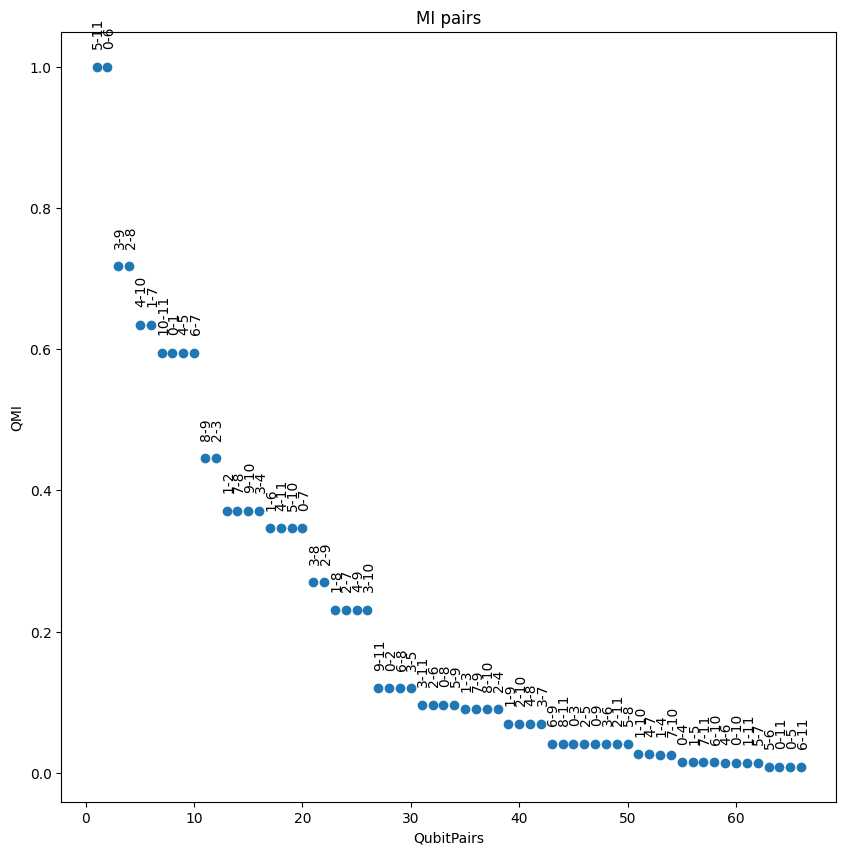

In [117]:
plt.figure(figsize=(10,10))
plt.title("MI pairs")
plt.ylabel("QMI")
plt.xlabel("QubitPairs")
plt.scatter(x=idx, y=vals,)

for i, txt in enumerate(labels):
    plt.annotate(txt, (idx[i]-0.5, vals[i]+0.03), rotation=90)

6 PARAMETERS CLUSTERING\
K-MEANS


In [358]:
def get_single_vqe_su4(paramslist,ent,depth,offset):
    ct = len(ent)
    n = len(set(np.array(ent).flatten()))
    paramslist = paramslist[n::]
    sliced = []
    for i in range(depth):
        for _ in range(ct):
            if i > (offset-1):
                sliced.append(paramslist[:6:])
            paramslist = paramslist[6::]
        paramslist = paramslist[n::]
    
    return np.mod(sliced, 2*np.pi)

def extract_su4(ent,f,size,depth):
    for i in range(1,size+1):
        p = pd.read_pickle(f.format(i,depth))[0]
        if i == 1:
            conc = get_single_vqe_su4(p["Optimal_params"],ent, depth,0)
        else:
            conc = np.concatenate((conc, get_single_vqe_su4(p["Optimal_params"],ent, depth,0)), axis=0)
    print(conc)
    return conc

def extract_parameters(s):
    print(s)
    return 0
    df = dict()
    for i in range(su4.shape[1]):
        df.update({"t{}".format(i+1):su4[:,i]})
    return df

In [ ]:
file_qida = "./pickle/vqe{}_3x3_{}A+_SU4.pkl"
d = np.array(extract_su4(ENTANGLER_MAP_QIDA, file_qida, 50, 1))
print(d[:,2])

In [191]:
from sklearn.datasets import make_blobs
cols = ['t1','t2','t3','t4','t5','t6']

#r = np.random.uniform(size = (100,6), low=-np.pi, high=np.pi)
t1 = []
for group in x_param:
    for l in group:
        t1.append(np.mod(l,2*np.pi))
t2 = []
for group in y_param:
    for l in group:
        t2.append(np.mod(l, 2*np.pi))
#X,Y= make_blobs(1000,2)
data.update({"t1":t1, "t2":t2})
df = []
df = pd.DataFrame(data=data)

In [144]:
def angle_to_euc(df):
    for c in df:
        df['cos_{}'.format(df[c].name)] = np.cos(df[c])
        df['sin_{}'.format(df[c].name)] = np.sin(df[c])

In [145]:
angle_to_euc(df)

In [192]:
df

,t3,t1,t2,t5,t6,t4
0,5.848964,4.505714,0.448773,4.536451,1.734834,2.207574
1,4.457310,3.696147,6.005713,1.869293,0.691484,4.472288
2,1.842280,4.263464,3.503066,0.356835,0.125353,1.635251
3,4.447968,3.002725,5.548745,0.586405,2.614222,1.306396
4,1.832994,6.138442,0.796795,0.571160,1.972831,4.440131
...,...,...,...,...,...,...
3460,4.440903,5.498240,5.469391,0.271144,1.175788,1.425526
3461,1.306370,1.854523,1.854188,6.129069,2.152436,4.449643
3462,4.842395,0.931558,6.204602,4.678992,4.044509,1.843055
3463,1.321072,4.730829,4.908971,2.998243,4.065909,4.459227


In [274]:

from sklearn import cluster
from matplotlib import pyplot as plt
import numpy as np

def kmeansshow(k,X):

    kmeans = cluster.KMeans(n_clusters=k)
    kmeans.fit_transform(X)

    labels = kmeans.labels_
    centroids = kmeans.cluster_centers_
    #print centroids

    for i in range(k):
        ds = X[np.where(labels==i)]
        plt.plot(ds[:,1],ds[:,2],'o')
        #lines = plt.plot(centroids[i,2],centroids[i,3],'kx')
        #plt.setp(lines,ms=15.0)
        #plt.setp(lines,mew=2.0)
    plt.show()
    return centroids

/home/fabio/.local/lib/python3.10/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


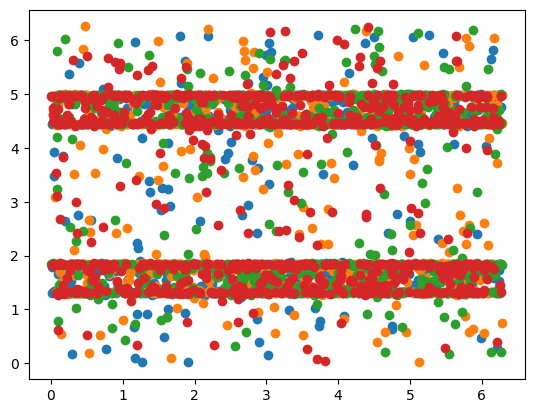

In [275]:
c = kmeansshow(4,df[['t1','t2','t3','t4','t5','t6']].values)

In [271]:
c

array([[2.82501068, 3.23767793, 3.05619941, 3.33100007, 4.86115926,
        1.61233593],
       [1.40116383, 2.99473524, 3.13560036, 3.0115138 , 3.06101169,
        4.58910311],
       [4.88245489, 3.37447492, 3.21181071, 3.21707882, 3.41280812,
        4.65890331],
       [3.29385719, 3.01514809, 3.22990212, 3.10254287, 1.37658068,
        1.68764161]])

In [102]:
angle = -np.pi/2
print(np.array([[np.cos(angle/2), -np.sin(angle/2)],[np.sin(angle/2), np.cos(angle/2)]]))

print(np.array([[np.exp(-1j*angle/2),0],[0,np.exp(1j*angle/2)]]))

[[ 0.70710678  0.70710678]
 [-0.70710678  0.70710678]]
[[0.70710678+0.70710678j 0.        +0.j        ]
 [0.        +0.j         0.70710678-0.70710678j]]


In [99]:
H = 1/np.sqrt(2)*np.array([[1,1],[1,-1]])
r = np.array([[np.exp(-1j*angle/2),0],[0,np.exp(1j*angle/2)]])

print(H@r@H)

[[6.12323400e-17+2.23711432e-17j 1.39778926e-33-1.00000000e+00j]
 [1.39778926e-33-1.00000000e+00j 6.12323400e-17+2.23711432e-17j]]


In [311]:
print(np.linalg.det(compose_su4(np.random.uniform(size = 15, low = -np.pi, high = np.pi))))

(-1.000000000000001-1.1102230246251578e-16j)


In [313]:
p = np.random.uniform(size = 15, low = -np.pi, high = np.pi)
print(compose_su4(p) @ compose_su4(p).conj().T)

[[ 1.00000000e+00+0.00000000e+00j -2.77555756e-17-9.71445147e-17j
   7.28583860e-17-2.77555756e-17j -9.71445147e-17+1.38777878e-17j]
 [-2.77555756e-17+9.71445147e-17j  1.00000000e+00+0.00000000e+00j
   4.85722573e-17+2.77555756e-17j  1.00613962e-16+0.00000000e+00j]
 [ 7.28583860e-17+2.77555756e-17j  4.85722573e-17-2.77555756e-17j
   1.00000000e+00+0.00000000e+00j  4.16333634e-17-6.93889390e-17j]
 [-9.71445147e-17-1.38777878e-17j  1.00613962e-16+0.00000000e+00j
   4.16333634e-17+6.93889390e-17j  1.00000000e+00+0.00000000e+00j]]
